In [1]:
import os, random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# Reproductibilité
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
splits = {'train': 'train.json', 'validation': 'validation.json'}

train_df = pd.read_json("hf://datasets/sander-wood/irishman/" + splits["train"])
val_df   = pd.read_json("hf://datasets/sander-wood/irishman/" + splits["validation"])

print("Nombre de chansons dans le train :", len(train_df))
print("Nombre de chansons dans la validation :", len(val_df))

first_song = train_df.loc[0, "abc notation"]
print("\n--- Première chanson (extrait) ---\n")
print(first_song[:1000])

Nombre de chansons dans le train : 214122
Nombre de chansons dans la validation : 2162

--- Première chanson (extrait) ---

X:1
L:1/8
M:4/4
K:Emin
|: E2 EF E2 EF | DEFG AFDF | E2 EF E2 B2 |1 efe^d e2 e2 :|2 efe^d e3 B |: e2 ef g2 fe | 
 defg afdf |1 e2 ef g2 fe | efe^d e3 B :|2 g2 bg f2 af | efe^d e2 e2 ||


In [3]:
PAD_TOKEN = " "  

all_text = "".join(train_df["abc notation"].tolist())
unique_chars = sorted(list(set(all_text)))

if PAD_TOKEN not in unique_chars:
    unique_chars = [PAD_TOKEN] + unique_chars

print("Nombre de caractères uniques :", len(unique_chars))
print("Exemples:", unique_chars[:40])

Nombre de caractères uniques : 95
Exemples: ['\n', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G']


In [4]:
char2idx = {ch: i for i, ch in enumerate(unique_chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

print("Index de 'E' (si présent) :", char2idx.get("E", "pas dans vocab"))
print("Caractère à l'index 10 :", idx2char[10])

Index de 'E' (si présent) : 37
Caractère à l'index 10 : *


In [5]:
lengths = train_df["abc notation"].apply(len)
print("Max length train:", lengths.max())
print("Mean length train:", int(lengths.mean()))

MAX_LEN = 256   

Max length train: 2968
Mean length train: 290


In [6]:
def pad_or_truncate(text, max_len, pad_char=" "):
    text = str(text)
    if len(text) < max_len:
        return text + pad_char * (max_len - len(text))
    return text[:max_len]

def vectorize(text, char2idx, max_len):
    text = pad_or_truncate(text, max_len, pad_char=PAD_TOKEN)
    return [char2idx.get(ch, char2idx[PAD_TOKEN]) for ch in text]

train_vec = [vectorize(s, char2idx, MAX_LEN) for s in train_df["abc notation"]]
val_vec   = [vectorize(s, char2idx, MAX_LEN) for s in val_df["abc notation"]]

print("Exemple vectorisé (20 premiers indices):", train_vec[0][:20])
print("Longueur séquence:", len(train_vec[0]))

Exemple vectorisé (20 premiers indices): [56, 26, 17, 0, 44, 26, 17, 15, 24, 0, 45, 26, 20, 15, 20, 0, 43, 26, 37, 77]
Longueur séquence: 256


In [7]:
class MusicDataset(Dataset):
    def __init__(self, vectorized_data):
        self.data = vectorized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        x = seq[:-1]  
        y = seq[1:]   
        return x, y

train_loader_test = DataLoader(MusicDataset(train_vec), batch_size=8, shuffle=True)
x_b, y_b = next(iter(train_loader_test))

print("x_b shape:", x_b.shape)  
print("y_b shape:", y_b.shape)
print("Extrait x:", x_b[0][:30].tolist())
print("Extrait y:", y_b[0][:30].tolist())


x_b shape: torch.Size([8, 255])
y_b shape: torch.Size([8, 255])
Extrait x: [56, 26, 17, 20, 20, 22, 16, 21, 0, 44, 26, 17, 15, 17, 22, 0, 45, 26, 19, 15, 20, 0, 43, 26, 39, 0, 92, 26, 1, 39]
Extrait y: [26, 17, 20, 20, 22, 16, 21, 0, 44, 26, 17, 15, 17, 22, 0, 45, 26, 19, 15, 20, 0, 43, 26, 39, 0, 92, 26, 1, 39, 18]


In [8]:
class MusicRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_size=1024, num_layers=1, dropout=0.0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embedding(x)               
        out, hidden = self.lstm(emb, hidden)  
        logits = self.fc(out)                
        return logits, hidden

In [9]:
MAX_LEN = 128         
num_training_iterations = 50
batch_size = 64
learning_rate = 1e-3
embedding_dim = 128
hidden_size = 512
patience = 5


In [10]:
train_loader = DataLoader(MusicDataset(train_vec), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(MusicDataset(val_vec), batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

Train batches: 3345 Val batches: 34


In [11]:
def train_model_csv(
    model, train_loader, val_loader,
    num_iterations=3000, lr=5e-3,
    patience=8,
    save_path="best_music_rnn.pt",
    csv_path="training_log.csv"
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val = float("inf")
    bad_epochs = 0
    logs = []

    for epoch in range(1, num_iterations + 1):
        model.train()
        train_loss = 0.0
        train_acc  = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits, _ = model(x)

            loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            train_loss += loss.item()
            train_acc  += (logits.argmax(-1) == y).float().mean().item()

        train_loss /= len(train_loader)
        train_acc  /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_acc  = 0.0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits, _ = model(x)
                loss = criterion(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
                val_loss += loss.item()
                val_acc  += (logits.argmax(-1) == y).float().mean().item()

        val_loss /= len(val_loader)
        val_acc  /= len(val_loader)

        print(f"Epoch {epoch}/{num_iterations} | "
              f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
              f"Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

        logs.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            bad_epochs = 0
            torch.save({
                "model_state": model.state_dict(),
                "char2idx": char2idx,
                "idx2char": idx2char,
                "max_len": MAX_LEN,
                "vocab_size": len(char2idx),
                "embedding_dim": embedding_dim,
                "hidden_size": hidden_size
            }, save_path)
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("Early stopping déclenché.")
                break

        pd.DataFrame(logs).to_csv(csv_path, index=False)

    print("Best val loss:", best_val)
    print("Modèle sauvegardé:", save_path)
    print("Logs CSV:", csv_path)
    return pd.DataFrame(logs)

In [ ]:
model = MusicRNN(
    vocab_size=len(char2idx),
    embedding_dim=embedding_dim,
    hidden_size=hidden_size
).to(device)

logs_df = train_model_csv(
    model,
    train_loader,
    val_loader,
    num_iterations=num_training_iterations,
    lr=learning_rate,
    patience=8,
    save_path="best_music_rnn.pt",
    csv_path="training_log.csv"
)

logs_df.tail()


Epoch 1/50 | Train Loss 0.9642 Acc 0.6915 | Val Loss 0.8283 Acc 0.7308
Epoch 2/50 | Train Loss 0.7929 Acc 0.7379 | Val Loss 0.7741 Acc 0.7477
Epoch 3/50 | Train Loss 0.7505 Acc 0.7517 | Val Loss 0.7490 Acc 0.7560
Epoch 4/50 | Train Loss 0.7280 Acc 0.7592 | Val Loss 0.7302 Acc 0.7624
Epoch 5/50 | Train Loss 0.7135 Acc 0.7640 | Val Loss 0.7165 Acc 0.7663
Epoch 6/50 | Train Loss 0.7026 Acc 0.7677 | Val Loss 0.7199 Acc 0.7664
Epoch 7/50 | Train Loss 0.6950 Acc 0.7703 | Val Loss 0.7042 Acc 0.7710
Epoch 8/50 | Train Loss 0.6879 Acc 0.7727 | Val Loss 0.7098 Acc 0.7695
Epoch 9/50 | Train Loss 0.6824 Acc 0.7746 | Val Loss 0.6969 Acc 0.7740
Epoch 10/50 | Train Loss 0.6780 Acc 0.7760 | Val Loss 0.6942 Acc 0.7744
Epoch 11/50 | Train Loss 0.6726 Acc 0.7778 | Val Loss 0.6890 Acc 0.7762
Epoch 12/50 | Train Loss 0.6692 Acc 0.7790 | Val Loss 0.6880 Acc 0.7771
Epoch 13/50 | Train Loss 0.6657 Acc 0.7801 | Val Loss 0.6867 Acc 0.7772
Epoch 14/50 | Train Loss 0.6626 Acc 0.7812 | Val Loss 0.6843 Acc 0.7782
E

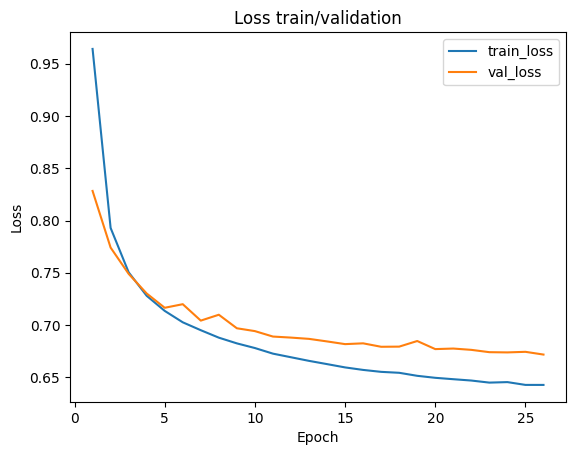

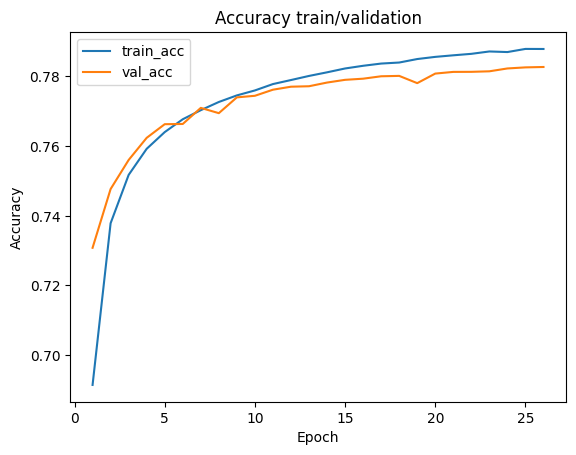

In [13]:
logs = pd.read_csv("training_log.csv")

plt.figure()
plt.plot(logs["epoch"], logs["train_loss"], label="train_loss")
plt.plot(logs["epoch"], logs["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss train/validation")
plt.show()

plt.figure()
plt.plot(logs["epoch"], logs["train_acc"], label="train_acc")
plt.plot(logs["epoch"], logs["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy train/validation")
plt.show()

In [16]:
def generate_music(model, start_sequence, char2idx, idx2char, length=200, temperature=1.1, top_k=20):
    model.eval()
    model.to(device)
    input_ids = [char2idx.get(ch, char2idx[PAD_TOKEN]) for ch in start_sequence]
    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

    generated = list(start_sequence)
    hidden = None

    with torch.no_grad():
        for _ in range(length):
            logits, hidden = model(input_tensor, hidden)
            last_logits = logits[0, -1] / max(temperature, 0.8)

            probs = torch.softmax(last_logits, dim=-1)

            if top_k is not None:
                topv, topi = torch.topk(probs, k=top_k)
                topv = topv / topv.sum()
                next_idx = topi[torch.multinomial(topv, 1)].item()
            else:
                next_idx = torch.multinomial(probs, 1).item()

            next_char = idx2char[next_idx]
            generated.append(next_char)

            input_tensor = torch.tensor([[next_idx]], dtype=torch.long).to(device)

    return "".join(generated)

In [17]:
ckpt = torch.load("best_music_rnn.pt", map_location=device)

model2 = MusicRNN(
    vocab_size=ckpt["vocab_size"],
    embedding_dim=ckpt["embedding_dim"],
    hidden_size=ckpt["hidden_size"]
).to(device)

model2.load_state_dict(ckpt["model_state"])

char2idx_loaded = ckpt["char2idx"]
idx2char_loaded = ckpt["idx2char"]

start_sequence = "X:1\nT:MySong\nM:4/4\nK:C\n"
song = generate_music(
    model2,
    start_sequence,
    char2idx_loaded,
    idx2char_loaded,
    length=200,
    temperature=1.1,
    top_k=20
)

print("🎵 Chanson générée:\n")
print(song)

🎵 Chanson générée:

X:1
T:MySong
M:4/4
K:C
 C,2 |"G7" G,B,CD FC C2 |"Dm" DC D2 G7 F3 | FD E2 DC C2 |"G7" C3 D G,2 z D | DE F2 F E2 F | 
 GC D2 F2 E2 |"Dm" DEFA"Dm7" A |"G7" GF D2"C7" EDEC |"F" C D2 E F4- | F"C6" z2 C2 G2 | 
"F" AGFG A A3 |"Bbd
